In [94]:
import nibabel as nib

import pandas as pd
import raster_geometry as rg
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
import numpy as np

from multiprocessing import Pool

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from scipy.stats import norm

# Loading and formatting the data

In [95]:
subj="07"

In [96]:
behavior = pd.read_csv("subj"+subj+"/behavior/subj"+subj+".csv")

In [97]:
#atlas 
im = nib.load("output_atlas.nii")
atlas = im.get_fdata()
x, y, z = np.where(atlas>-1)
atlas_data=pd.DataFrame(np.transpose(np.array([x,y,z])),columns=['x','y','z'])
atlas_data['value']=np.transpose(atlas).flatten('F')
atlas_data['value']=round(atlas_data['value'])

In [98]:
atlas_data[atlas_data.value>0]

,x,y,z,value
11046,3,23,22,82.0
11047,3,23,23,86.0
11048,3,23,24,86.0
11097,3,24,21,82.0
11098,3,24,22,82.0
...,...,...,...,...
158828,48,30,20,87.0
158829,48,30,21,87.0
158830,48,30,22,87.0
158880,48,31,20,87.0


In [99]:
atlas[3,23,23]

85.99902332760394

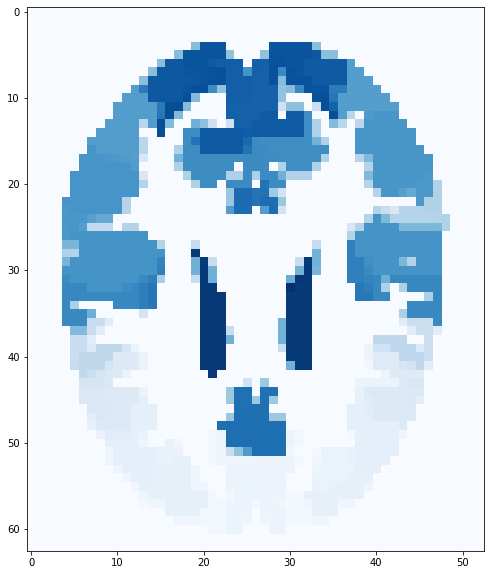

In [100]:
plt.imshow(atlas[:,:,30].T, cmap="Blues")

In [101]:
# import beta image
im = nib.load("subj"+subj+"/1stLevel_nob0_MVPA_trial_smooth/beta_0001.nii")
data = im.get_fdata()

In [102]:
x, y, z = np.where(data)
img_data=pd.DataFrame(np.transpose(np.array([x,y,z])),columns=['x','y','z'])

In [103]:
# todo: add recursively the betas of each trial - create matrix for classisifcation
img_data['beta']=np.transpose(data).flatten('F')#np.reshape(np.transpose(data),data.size,1)

In [104]:
img_data[~np.isnan(img_data.beta)]

,x,y,z,beta
52822,16,40,22,-1.229074
52823,16,40,23,-2.363679
56020,17,40,20,-0.449731
56021,17,40,21,-0.298963
56022,17,40,22,-0.530334
...,...,...,...,...
191016,59,55,16,0.090106
191054,59,56,14,0.529872
191055,59,56,15,-0.226308
194013,60,50,13,0.270830


In [105]:
data[16,40,22]

-1.2290737628936768

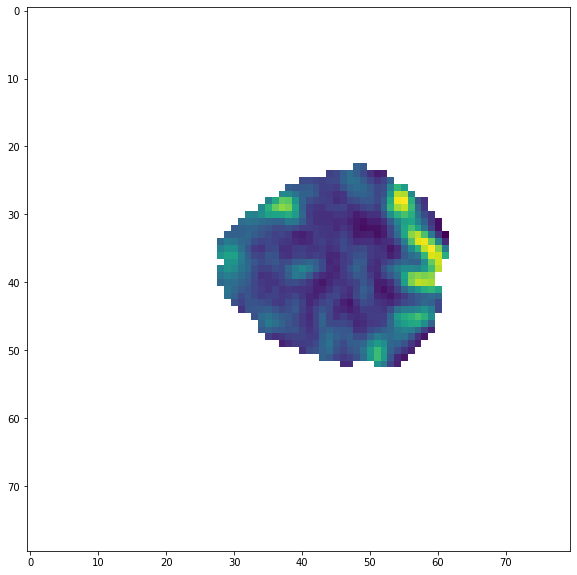

In [106]:
plt.imshow(data[:,:,30])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


(0.0, 40.0)

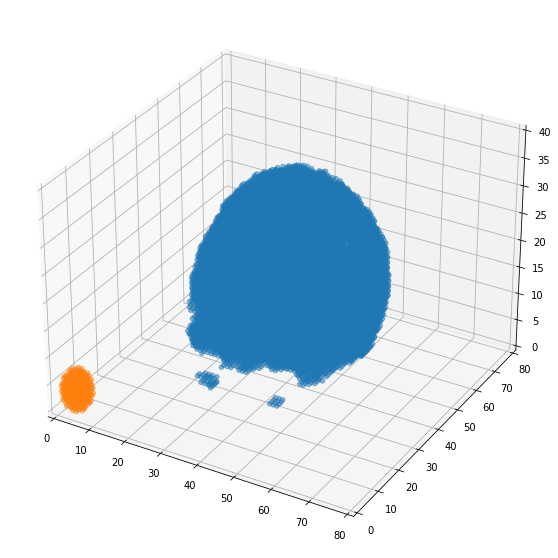

In [107]:

# brain
x, y, z = np.where(data>0)

# ROI
radius=4
center=(0.5)
arr = rg.sphere(radius*2, radius,center)  

plt.rcParams["figure.figsize"] = [10,10]

fig = plt.figure()
ax = fig.gca(projection='3d')
             
ax.scatter(x, y, z, cmap=plt.cm.YlGnBu_r,alpha=0.5)


# ROI
x2, y2, z2 = np.where(arr==1)
ax.scatter(x2, y2, z2, cmap=plt.cm.YlGnBu_r,alpha=0.5)

ax.set_xlim(0,80)
ax.set_ylim(0,80)
ax.set_zlim(0,40)

In [108]:
nb_vox_square_roi=arr.shape[0]

In [109]:
coord_brain=np.argwhere(~np.isnan(data))

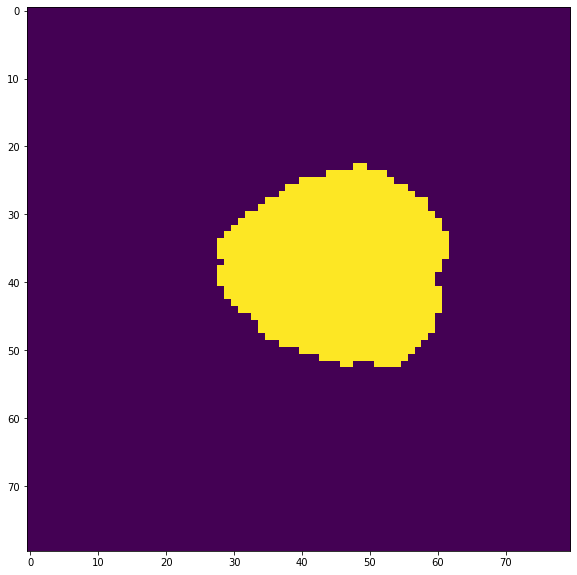

In [110]:
#use the mask to know voxels where data is
im = nib.load("subj"+subj+"/1stLevel_nob0_MVPA_trial_smooth/mask.nii")
mask_im = im.get_fdata()
coord_brain=np.argwhere(mask_im>0)
x, y, z = np.where(mask_im>-1)
data_table=pd.DataFrame(np.transpose(np.array([x,y,z])),columns=['x','y','z'])
# add whether mask is on or off to later use only voxels where there is brain
data_table['brain_mask']=np.transpose(mask_im).flatten('F')#np.reshape(np.transpose(mask_im),mask_im.size,1)
plt.imshow(mask_im[:,:,30])

In [111]:
# make beta table
ipath = "subj"+subj+"/preproc_img_MVPA_norm_smooth"
beta = "1stLevel_nob0_MVPA_trial_smooth"
betap = "subj"+subj+"/"+beta
beta = pd.read_csv(betap+"/"+"beta_names.csv")
betas = ["beta_"+str(i).zfill(4) +".nii" for i in range(1,220)]
beta["var2"] = betas
beta["len"] = beta["Var1"].apply(len)
beta_clean = beta.query("len > 20")
splits = beta_clean["Var1"].str.split("_",expand=True)
beta_df = beta_clean.join(splits)
beta_df.head()
beta_df["labels"] = beta_df[2].map({"defect":0, "cooperate":1})
beta_df = beta_df.rename(columns={"var2":"files"})
#reset index because we removed rows 
beta_df=beta_df.reset_index()

#labels

labels=beta_df['labels'].values

In [112]:
# loop through betas and write their coordinates in the table
for b in range(len(beta_df)):
    im = nib.load("subj"+subj+"/1stLevel_nob0_MVPA_trial_smooth/"+beta_df.files[b])
    beta_im = im.get_fdata()
    x, y, z = np.where(beta_im)
    data_table['beta'+str(b)]=np.transpose(beta_im).flatten('F')#np.reshape(np.transpose(beta_im),beta_im.size,1)

In [113]:
# remove voxels where there is no brains
data_table_brain=data_table[data_table.brain_mask==1]
data_table_brain=data_table_brain.reset_index()

In [114]:
data_table_brain

,index,x,y,z,brain_mask,beta0,beta1,beta2,beta3,beta4,...,beta181,beta182,beta183,beta184,beta185,beta186,beta187,beta188,beta189,beta190
0,52822,16,40,22,1.0,-1.229074,-0.805963,-0.297935,-0.163847,0.182918,...,-0.221454,-0.238561,0.831932,0.609677,-0.084214,-0.247967,0.114771,2.228426,0.263689,-0.633826
1,52823,16,40,23,1.0,-2.363679,-2.305389,-1.065661,-0.392785,0.032846,...,0.292821,-0.091164,-0.165593,0.526369,0.308264,0.719846,-0.066404,1.368657,0.092466,-1.100109
2,56020,17,40,20,1.0,-0.449731,0.285561,0.231434,-0.259287,-0.154440,...,-0.312200,0.130203,-0.820997,0.103039,-0.202245,-0.370527,-0.533458,0.788491,0.258771,-0.098440
3,56021,17,40,21,1.0,-0.298963,0.421030,-0.017452,-0.140478,0.084158,...,-0.203351,-0.307324,-0.274748,0.243722,-0.224277,-0.350642,-0.388561,1.457831,-0.079234,-0.278202
4,56022,17,40,22,1.0,-0.530334,-0.211632,-0.301656,-0.157563,0.112100,...,0.000642,-0.530604,0.162644,0.337880,-0.100026,-0.363727,0.133595,1.688605,0.059616,-0.429690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42051,191016,59,55,16,1.0,0.090106,-1.279704,-1.100631,-0.655299,-1.297275,...,0.298943,-0.422295,-0.880350,-0.959849,-0.485185,-0.731266,0.287251,-1.064934,-0.595795,-0.258951
42052,191054,59,56,14,1.0,0.529872,-0.993518,-0.033564,-0.836715,-0.996645,...,0.004142,-0.790687,-1.294891,-0.197955,-0.222258,-0.837672,0.504493,0.013569,-0.257607,0.240635
42053,191055,59,56,15,1.0,-0.226308,-0.692832,-0.735580,-0.571725,-0.924641,...,-0.172764,-0.793586,-0.947415,-0.345030,-0.430339,-0.994608,0.059737,-0.475948,-0.488595,-0.282590
42054,194013,60,50,13,1.0,0.270830,0.179460,0.633116,0.611492,0.073065,...,-0.016673,0.336377,-1.023799,-0.357921,-0.199564,0.170040,0.326779,0.368133,0.344485,0.659673


In [115]:
data_use=data_table.T
data_use=data_use.drop(labels=['x','y','z','brain_mask'], axis=0)

In [116]:
labels

array([0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1])

# Searchlight analysis

In [24]:
# define the type of sphere we want
# ROI
radius=4
center=(0.5)
arr = rg.sphere(radius*2, radius,center)  

# initialize classification
y=labels
clf = svm.SVC(kernel='linear', C=1, random_state=42)

# intialize the score vector
mean_acc= np.zeros(shape = (coord_brain.shape[0],1))
std_acc=np.zeros(shape = (coord_brain.shape[0],1))

[0.5        0.5        0.5        0.59574468]
CPU times: user 8.63 s, sys: 228 ms, total: 8.85 s
Wall time: 7.78 s


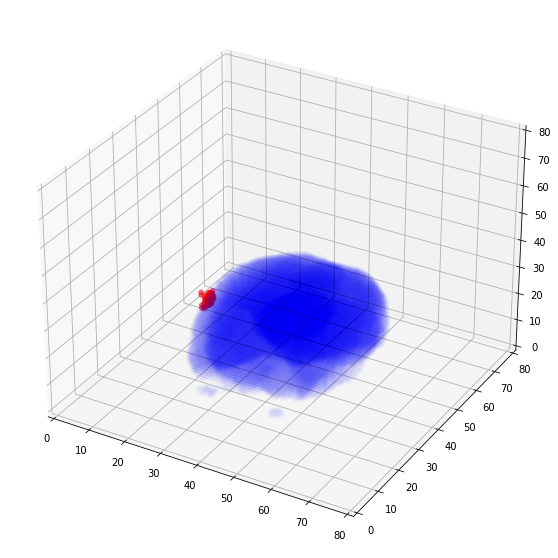

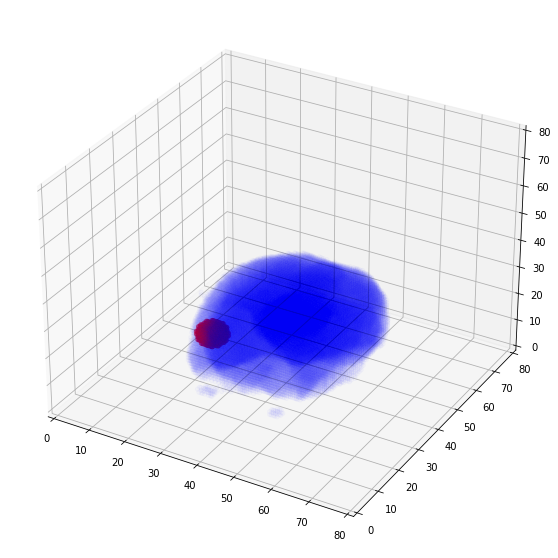

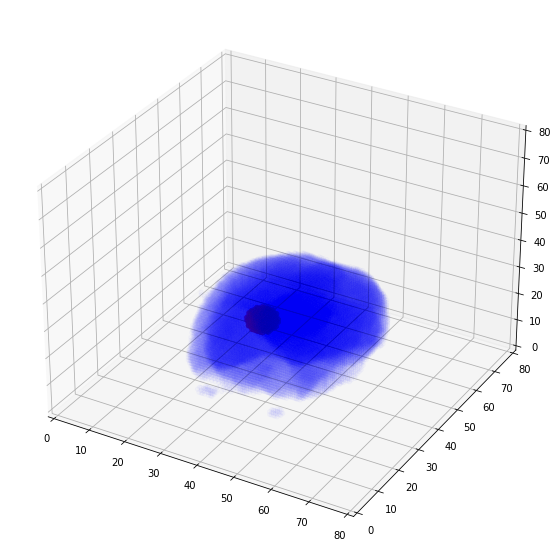

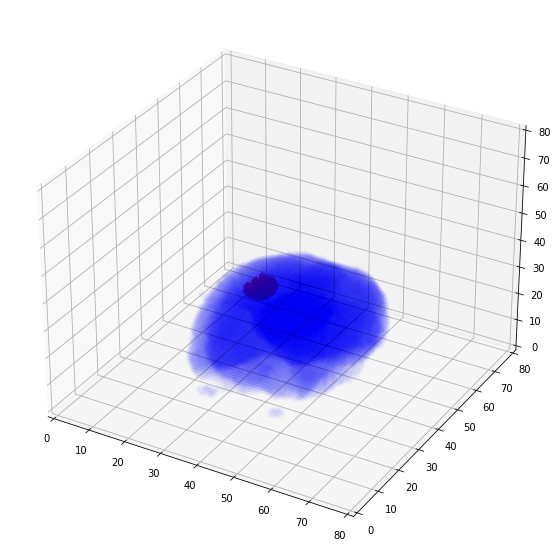

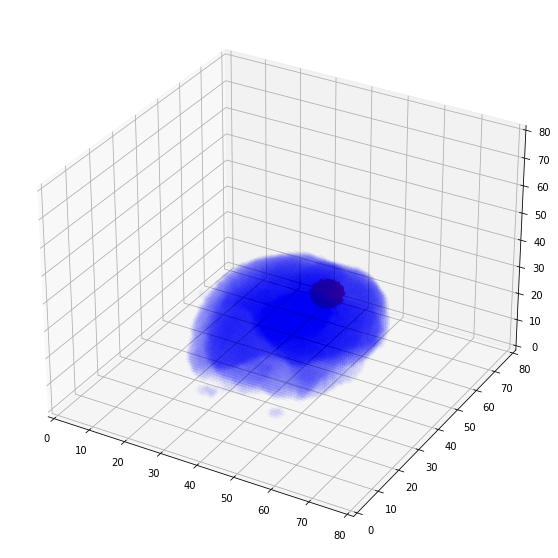

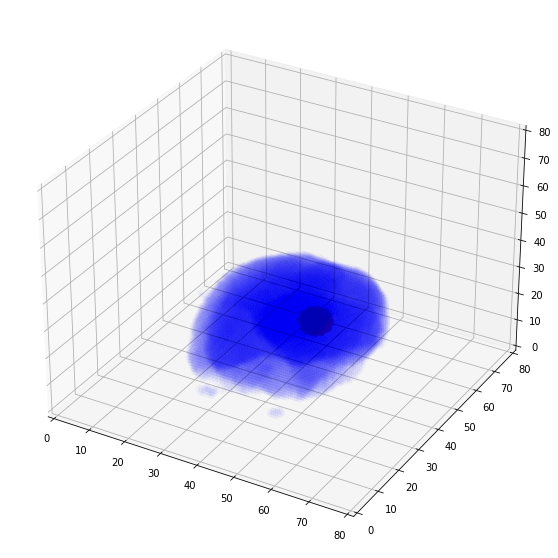

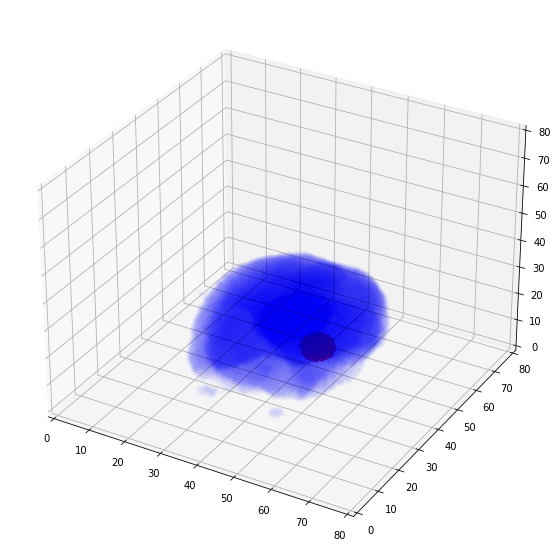

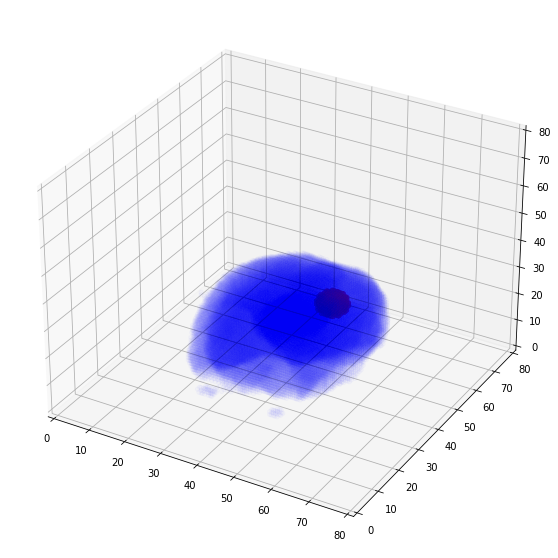

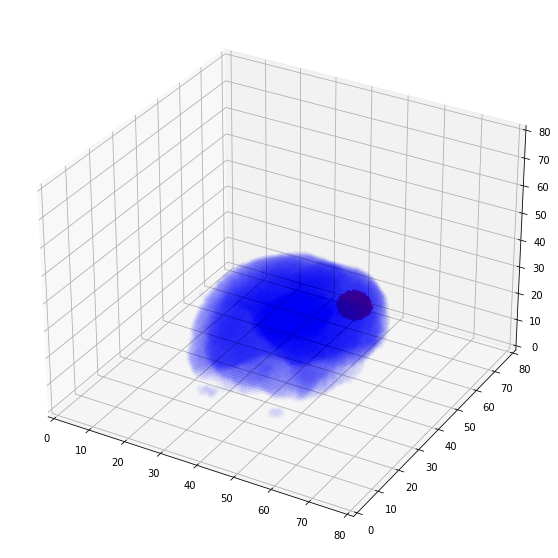

In [29]:
%%time

# loop through voxels and run classification
for vox in range(0,coord_brain.shape[0],1000):
    
    data_roi=np.copy(mask_im)
    data_roi[:] = np.nan
    
    #localisation of the center voxel
    coord_center = coord_brain[vox,:]
    
    # sphere around it
    
    # square
    dat_roi=mask_im[max(coord_center[0]-radius,0):min(coord_center[0]+radius,mask_im.shape[0]),max(coord_center[1]-radius,0):min(coord_center[1]+radius,mask_im.shape[1]),max(coord_center[2]-radius,0):min(coord_center[2]+radius,mask_im.shape[2])]
    
    
    #multiply by sphere
    # pb if the voxels are outside the mask image
    if any(coord_center-radius<0) or any(coord_center+radius>mask_im.shape):
        #remove bottom row
        if coord_center[0]-radius<0:
            roi_sphere=np.multiply(dat_roi,arr[radius-coord_center[0]:,:,:])
        elif coord_center[1]-radius<0:
            roi_sphere=np.multiply(dat_roi,arr[:,radius-coord_center[1]:,:])
        elif coord_center[2]-radius<0:
            roi_sphere=np.multiply(dat_roi,arr[:,:,radius-coord_center[2]:])
        
        # remove top row
        if coord_center[0]+radius>mask_im.shape[0]:
            roi_sphere=np.multiply(dat_roi,arr[:coord_center[0]-radius,:,:])
        elif coord_center[1]+radius>mask_im.shape[1]:
            roi_sphere=np.multiply(dat_roi,arr[:,:coord_center[1]-radius,:])
        elif coord_center[2]+radius>mask_im.shape[2]:
            roi_sphere=np.multiply(dat_roi,arr[:,:,:coord_center[2]-radius])            
    else:
        roi_sphere=np.multiply(dat_roi,arr)
  
    roi_sphere[roi_sphere==0]=np.nan
    
    # replace in the big array
    data_roi[max(coord_center[0]-radius,0):min(coord_center[0]+radius,mask_im.shape[0]),max(coord_center[1]-radius,0):min(coord_center[1]+radius,mask_im.shape[1]),max(coord_center[2]-radius,0):min(coord_center[2]+radius,mask_im.shape[2])]=roi_sphere
    
    # make the array into a 2d matrix and find the indexes where there are ones -> these are used to read into the betas table
    ix_use=~np.isnan(np.transpose(data_roi).flatten('F'))
    
    # data for classification: select only the columns corresponding to the sphere
    X=data_use.loc[:,ix_use]
    
    # X are the features
    # Y are the labels

  
    scores = cross_val_score(clf, X, labels, cv=KFold(n_splits=4, random_state=None, shuffle=False))
    mean_acc[vox]=np.mean(scores)
    std_acc[vox]=np.std(scores)

    
    #plot the brain and the ROI for some of them
    if vox%5000==0:
        plt.rcParams["figure.figsize"] = [10,10]

        fig = plt.figure()
        ax = fig.gca(projection='3d')

        # brain
        x, y, z = np.where(mask_im>0)
        ax.scatter(x, y, z, cmap=plt.cm.YlGnBu_r,color='blue',alpha=0.02)

        # ROI
        x2, y2, z2 = np.where(~np.isnan(data_roi))
        ax.scatter(x2, y2, z2, cmap=plt.cm.YlGnBu_r,color='red',alpha=0.5)

        ax.set_xlim(0,80)
        ax.set_ylim(0,80)
        ax.set_zlim(0,80)

        
print(scores)

In [30]:
# compute the confidence intervals lower bounds

alpha = 0.95
n=4
# Define our z
ci = alpha + (1-alpha)/2
#Lower Interval, where n is sample siz
c_lb = mean_acc - norm.ppf(ci)*((std_acc/(n**0.5)))
c_ub = mean_acc  + norm.ppf(ci)*((std_acc/(n**0.5)))

In [33]:
c_lb[c_lb>0.5]

array([0.54227574, 0.50091361])

# Parallelisation: multiprocessing

In [34]:
%%time
# same thing but parallelized 
alpha = 0.95
n=4
def f(vox):
    
    data_roi=np.copy(mask_im)
    data_roi[:] = np.nan
    
    #localisation of the center voxel
    coord_center = coord_brain[vox,:]
    
    # sphere around it
    
    # square
    dat_roi=mask_im[max(coord_center[0]-radius,0):min(coord_center[0]+radius,mask_im.shape[0]),max(coord_center[1]-radius,0):min(coord_center[1]+radius,mask_im.shape[1]),max(coord_center[2]-radius,0):min(coord_center[2]+radius,mask_im.shape[2])]
    
    
    #multiply by sphere
    # pb if the voxels are outside the mask image
    if any(coord_center-radius<0) or any(coord_center+radius>mask_im.shape):
        # remove bottom row
        if coord_center[0]-radius<0:
            roi_sphere=np.multiply(dat_roi,arr[radius-coord_center[0]:,:,:])
        elif coord_center[1]-radius<0:
            roi_sphere=np.multiply(dat_roi,arr[:,radius-coord_center[1]:,:])
        elif coord_center[2]-radius<0:
            roi_sphere=np.multiply(dat_roi,arr[:,:,radius-coord_center[2]:])
        
        # remove top row
        if coord_center[0]+radius>mask_im.shape[0]:
            roi_sphere=np.multiply(dat_roi,arr[:coord_center[0]-radius,:,:])
        elif coord_center[1]+radius>mask_im.shape[1]:
            roi_sphere=np.multiply(dat_roi,arr[:,:coord_center[1]-radius,:])
        elif coord_center[2]+radius>mask_im.shape[2]:
            roi_sphere=np.multiply(dat_roi,arr[:,:,:coord_center[2]-radius])            
    else:
        roi_sphere=np.multiply(dat_roi,arr)
  
    roi_sphere[roi_sphere==0]=np.nan
    
    # replace in the big array
    data_roi[max(coord_center[0]-radius,0):min(coord_center[0]+radius,mask_im.shape[0]),max(coord_center[1]-radius,0):min(coord_center[1]+radius,mask_im.shape[1]),max(coord_center[2]-radius,0):min(coord_center[2]+radius,mask_im.shape[2])]=roi_sphere
    
    # make the array into a 2d matrix and find the indexes where there are ones -> these are used to read into the betas table
    ix_use=~np.isnan(np.transpose(data_roi).flatten('F'))
    
    # data for classification: select only the columns corresponding to the sphere
    X=data_use.loc[:,ix_use]
    
    # X are the features
    # Y are the labels

  
    scores = cross_val_score(clf, X, labels, cv=KFold(n_splits=4, random_state=None, shuffle=False))
    mean_a=np.mean(scores)
    std_a=np.std(scores)
    
    ci = alpha + (1-alpha)/2
    #Lower Interval, where n is sample siz
    c_lb = mean_a - norm.ppf(ci)*((std_a/(n**0.5)))
    
    return c_lb 

if __name__ == '__main__':
    with Pool(processes=4) as pool:
           c_lb2 = pool.map(f, range(0,coord_brain.shape[0]))



CPU times: user 896 ms, sys: 239 ms, total: 1.13 s
Wall time: 35min 4s


In [35]:
data_table_brain['Acc_lb']=c_lb2
data_brain_plot=data_table_brain[data_table_brain.Acc_lb>0.5]

In [36]:
data_table_brain

,index,x,y,z,brain_mask,beta0,beta1,beta2,beta3,beta4,...,beta182,beta183,beta184,beta185,beta186,beta187,beta188,beta189,beta190,Acc_lb
0,52822,16,40,22,1.0,-1.229074,-0.805963,-0.297935,-0.163847,0.182918,...,-0.238561,0.831932,0.609677,-0.084214,-0.247967,0.114771,2.228426,0.263689,-0.633826,0.403786
1,52823,16,40,23,1.0,-2.363679,-2.305389,-1.065661,-0.392785,0.032846,...,-0.091164,-0.165593,0.526369,0.308264,0.719846,-0.066404,1.368657,0.092466,-1.100109,0.420087
2,56020,17,40,20,1.0,-0.449731,0.285561,0.231434,-0.259287,-0.154440,...,0.130203,-0.820997,0.103039,-0.202245,-0.370527,-0.533458,0.788491,0.258771,-0.098440,0.378548
3,56021,17,40,21,1.0,-0.298963,0.421030,-0.017452,-0.140478,0.084158,...,-0.307324,-0.274748,0.243722,-0.224277,-0.350642,-0.388561,1.457831,-0.079234,-0.278202,0.401185
4,56022,17,40,22,1.0,-0.530334,-0.211632,-0.301656,-0.157563,0.112100,...,-0.530604,0.162644,0.337880,-0.100026,-0.363727,0.133595,1.688605,0.059616,-0.429690,0.385071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42051,191016,59,55,16,1.0,0.090106,-1.279704,-1.100631,-0.655299,-1.297275,...,-0.422295,-0.880350,-0.959849,-0.485185,-0.731266,0.287251,-1.064934,-0.595795,-0.258951,0.367016
42052,191054,59,56,14,1.0,0.529872,-0.993518,-0.033564,-0.836715,-0.996645,...,-0.790687,-1.294891,-0.197955,-0.222258,-0.837672,0.504493,0.013569,-0.257607,0.240635,0.418518
42053,191055,59,56,15,1.0,-0.226308,-0.692832,-0.735580,-0.571725,-0.924641,...,-0.793586,-0.947415,-0.345030,-0.430339,-0.994608,0.059737,-0.475948,-0.488595,-0.282590,0.375026
42054,194013,60,50,13,1.0,0.270830,0.179460,0.633116,0.611492,0.073065,...,0.336377,-1.023799,-0.357921,-0.199564,0.170040,0.326779,0.368133,0.344485,0.659673,0.447980


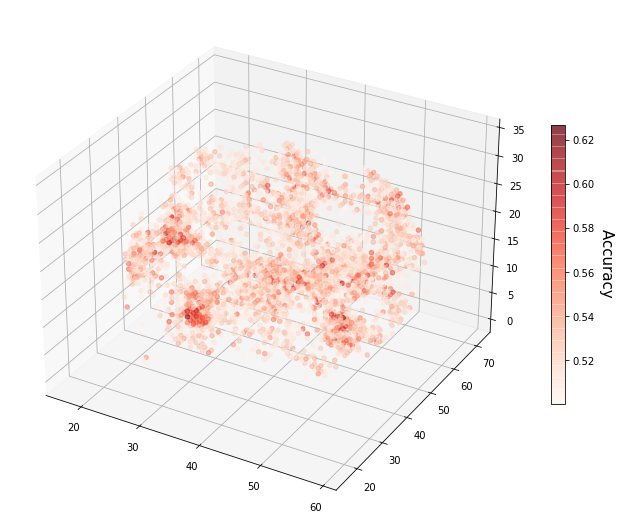

In [37]:
## plot the accuracy as a brain shape
plt.rcParams["figure.figsize"] = [10,10]
fig = plt.figure()
ax = fig.gca(projection='3d')

# brain
img=ax.scatter(data_brain_plot.x, data_brain_plot.y, data_brain_plot.z,c=data_brain_plot.Acc_lb, cmap='Reds',alpha=0.5)
cbar=fig.colorbar(img,fraction=0.025)
cbar.set_label('Accuracy ', rotation=270, fontsize = 15, labelpad=20)

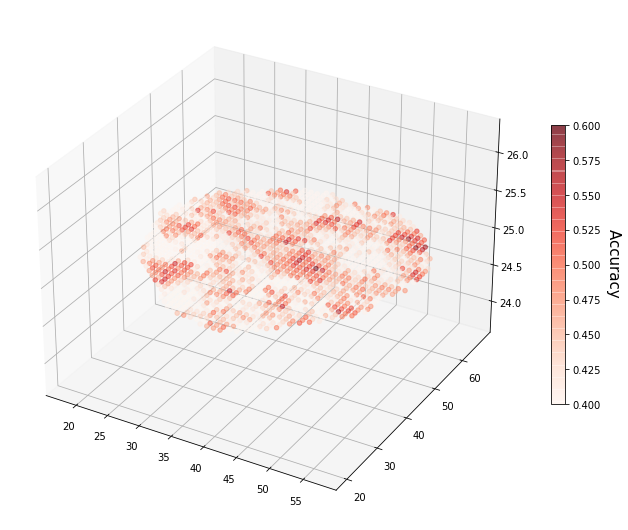

In [76]:
## plot the accuracy as a brain shape
plt.rcParams["figure.figsize"] = [10,10]
fig = plt.figure()
ax = fig.gca(projection='3d')
brain_slice = data_table_brain.query("z == 25")
# brain
img=ax.scatter(brain_slice.x, brain_slice.y, brain_slice.z,c=brain_slice.Acc_lb, cmap='Reds',alpha=0.5,vmin=0.4,vmax=0.6)
cbar=fig.colorbar(img,fraction=0.025)
cbar.set_label('Accuracy ', rotation=270, fontsize = 15, labelpad=20)

# Spark attempt

In [117]:
#reshape the data for spark: transpose and add a labels column

spark_table=data_table_brain.T
spark_table.head()



,0,1,2,3,4,5,6,7,8,9,...,42046,42047,42048,42049,42050,42051,42052,42053,42054,42055
index,52822.0,52823.0,56020.0,56021.0,56022.0,56060.0,56061.0,56062.0,56099.0,56100.0,...,190977.0,191012.0,191013.0,191014.0,191015.0,191016.0,191054.0,191055.0,194013.0,194053.0
x,16.0,16.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,...,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,60.0,60.0
y,40.0,40.0,40.0,40.0,40.0,41.0,41.0,41.0,42.0,42.0,...,54.0,55.0,55.0,55.0,55.0,55.0,56.0,56.0,50.0,51.0
z,22.0,23.0,20.0,21.0,22.0,20.0,21.0,22.0,19.0,20.0,...,17.0,12.0,13.0,14.0,15.0,16.0,14.0,15.0,13.0,13.0
brain_mask,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [118]:
spark_table_coord=spark_table.drop(labels=['brain_mask','index'], axis=0)

spark_table=spark_table.drop(labels=['x','y','z','brain_mask','index'], axis=0)

In [119]:
spark_table.head()

,0,1,2,3,4,5,6,7,8,9,...,42046,42047,42048,42049,42050,42051,42052,42053,42054,42055
beta0,-1.229074,-2.363679,-0.449731,-0.298963,-0.530334,-0.487975,-0.317970,-0.934334,-0.893969,-0.359861,...,-0.146650,0.643979,0.563926,0.068705,-0.066657,0.090106,0.529872,-0.226308,0.270830,0.215859
beta1,-0.805963,-2.305389,0.285561,0.421030,-0.211632,0.233655,0.267838,-0.200105,-0.366909,0.102880,...,-1.411781,-1.104698,-1.291548,-1.127353,-1.140023,-1.279704,-0.993518,-0.692832,0.179460,0.258496
beta2,-0.297935,-1.065661,0.231434,-0.017452,-0.301656,0.387243,0.109775,-0.041567,0.029094,-0.043859,...,-1.327541,-0.072892,-0.223485,-0.188619,-0.712824,-1.100631,-0.033564,-0.735580,0.633116,0.364229
beta3,-0.163847,-0.392785,-0.259287,-0.140478,-0.157563,-0.205982,-0.175538,0.108026,-0.024100,-0.124697,...,-0.750673,-1.432230,-1.407551,-0.893988,-0.870924,-0.655299,-0.836715,-0.571725,0.611492,0.339897
beta4,0.182918,0.032846,-0.154440,0.084158,0.112100,-0.316986,-0.120521,0.121265,-0.468960,-0.297249,...,-0.812209,-1.810645,-1.788533,-1.201403,-1.327784,-1.297275,-0.996645,-0.924641,0.073065,-0.111473


In [120]:
# insert a label column

spark_table.insert(loc=0, column='label', value=beta_df['labels'].values)


In [121]:
spark_table.head()

,label,0,1,2,3,4,5,6,7,8,...,42046,42047,42048,42049,42050,42051,42052,42053,42054,42055
beta0,0,-1.229074,-2.363679,-0.449731,-0.298963,-0.530334,-0.487975,-0.317970,-0.934334,-0.893969,...,-0.146650,0.643979,0.563926,0.068705,-0.066657,0.090106,0.529872,-0.226308,0.270830,0.215859
beta1,0,-0.805963,-2.305389,0.285561,0.421030,-0.211632,0.233655,0.267838,-0.200105,-0.366909,...,-1.411781,-1.104698,-1.291548,-1.127353,-1.140023,-1.279704,-0.993518,-0.692832,0.179460,0.258496
beta2,1,-0.297935,-1.065661,0.231434,-0.017452,-0.301656,0.387243,0.109775,-0.041567,0.029094,...,-1.327541,-0.072892,-0.223485,-0.188619,-0.712824,-1.100631,-0.033564,-0.735580,0.633116,0.364229
beta3,1,-0.163847,-0.392785,-0.259287,-0.140478,-0.157563,-0.205982,-0.175538,0.108026,-0.024100,...,-0.750673,-1.432230,-1.407551,-0.893988,-0.870924,-0.655299,-0.836715,-0.571725,0.611492,0.339897
beta4,1,0.182918,0.032846,-0.154440,0.084158,0.112100,-0.316986,-0.120521,0.121265,-0.468960,...,-0.812209,-1.810645,-1.788533,-1.201403,-1.327784,-1.297275,-0.996645,-0.924641,0.073065,-0.111473


In [124]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "15g") \
    .appName('my-cool-app') \
    .getOrCreate()

In [127]:
%%time
df = spark.createDataFrame(spark_table)

CPU times: user 54.2 s, sys: 1.19 s, total: 55.4 s
Wall time: 59.9 s


In [128]:
# run classification 
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

In [129]:
training, testing = df.randomSplit([0.6, 0.4], seed=42)


In [130]:
assembler = VectorAssembler(inputCols=training.columns[1:50], outputCol='features')

In [131]:
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[assembler, lr])

In [132]:
%%time
model = pipeline.fit(training)
prediction = model.transform(testing)

CPU times: user 47.4 ms, sys: 60.4 ms, total: 108 ms
Wall time: 2min 33s


In [134]:
# time it would take to run one classification per searchlight ROI
2.5*41712/60

1738.0

In [135]:
selected = prediction.select("features", "label", "probability", "prediction")
print ("Label vs. prediction", selected.show())

+--------------------+-----+--------------------+----------+
|            features|label|         probability|prediction|
+--------------------+-----+--------------------+----------+
|[-1.2290737628936...|    0|[0.55999360320202...|       0.0|
|[-0.2553172707557...|    0|[0.24232198619459...|       1.0|
|[-0.1120581328868...|    0|[0.48643481374451...|       1.0|
|[0.03949809446930...|    0|[0.46294082956744...|       1.0|
|[0.12227037549018...|    0|[0.61176543714531...|       0.0|
|[0.53529351949691...|    0|[0.76353066138735...|       0.0|
|[0.69036591053009...|    0|[0.91985619109332...|       0.0|
|[-0.9642471671104...|    1|[0.27152105566170...|       1.0|
|[-0.4653679132461...|    1|[0.83436885471552...|       0.0|
|[-0.3611900806427...|    1|[0.77118093663420...|       0.0|
|[-0.2340808063745...|    1|[0.35065134748045...|       1.0|
|[0.01111306156963...|    1|[0.16103413752220...|       1.0|
|[0.18291848897933...|    1|[0.35557367466245...|       1.0|
|[-1.4864308834075...|  

In [ ]:
numRows = selected.count()
correct = 0.0
for row in selected.collect():
	if row[1] == row[3]:
		correct = correct+1
#print(row)
accuracy = correct / numRows

In [ ]:
accuracy